In [18]:
!pip install tabulate
!pip install folium
!pip install colorama
!pip install geopy
!pip install pyswarm
!pip install pulp gurobipy

In [19]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tabulate import tabulate
import folium
from colorama import Fore, Style, init
from IPython.display import display
from geopy.distance import geodesic
from datetime import datetime

init()

# Print execution info
print(f"Execution Date and Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"User: kripa-sindhu-007\n")


Execution Date and Time: 2025-12-25 05:59:10
User: kripa-sindhu-007



In [20]:
# Family Car parameters
VEHICLE_PARAMS_FAMILY_CAR = {
    "mass": 1600,  # kg
    "wheel_radius": 0.30,  # meters
    "transmission_ratio": 4.0,
    "transmission_efficiency": 0.94,
    "drive_efficiency": 0.92,
    "a0": 100.0,    # N
    "a1": 1.5,      # N/(m/s)
    "a2": 0.40,     # N/(m/s)^2
    "motor_min_torque": -40,  # Nm
    "motor_max_torque": 180,  # Nm
    "acceleration": 2.5,      # m/s²
    "air_density": 1.225,     # kg/m³
    "gravity": 9.81,          # m/s²
    "battery_capacity": 60,   # kWh
    "initial_charge": np.random.uniform(30, 60),  # kWh
    "min_charge": 10,         # kWh
    "cost_per_kwh": np.random.uniform(1.40, 1.80),  # $/kWh
    "green_zone_penalty": 0.20,  # $
    "cost_per_kwh_gas": np.random.uniform(2.00, 2.20),  # $/kWh equivalent
}

# Sport Car parameters
VEHICLE_PARAMS_SPORT_CAR = {
    "mass": 1300,  # kg
    "wheel_radius": 0.32,  # meters
    "transmission_ratio": 3.8,
    "transmission_efficiency": 0.96,
    "drive_efficiency": 0.93,
    "a0": 80.0,     # N
    "a1": 1.2,      # N/(m/s)
    "a2": 0.30,     # N/(m/s)^2
    "motor_min_torque": -60,  # Nm
    "motor_max_torque": 250,  # Nm
    "acceleration": 4.5,      # m/s²
    "air_density": 1.225,     # kg/m³
    "gravity": 9.81,          # m/s²
    "battery_capacity": 75,   # kWh
    "initial_charge": np.random.uniform(40, 75),  # kWh
    "min_charge": 15,         # kWh
    "cost_per_kwh": np.random.uniform(1.40, 1.80),  # $/kWh
    "green_zone_penalty": 0.10,  # $
    "cost_per_kwh_gas": np.random.uniform(2.00, 2.20),  # $/kWh equivalent
}

# Heavy Vehicle parameters
VEHICLE_PARAMS_HEAVY_VEHICLE = {
    "mass": 3000,  # kg
    "wheel_radius": 0.40,  # meters
    "transmission_ratio": 6.0,
    "transmission_efficiency": 0.89,
    "drive_efficiency": 0.85,
    "a0": 200.0,   # N
    "a1": 2.5,     # N/(m/s)
    "a2": 1.00,    # N/(m/s)^2
    "motor_min_torque": -100,  # Nm
    "motor_max_torque": 300,   # Nm
    "acceleration": 1.0,       # m/s²
    "air_density": 1.225,      # kg/m³
    "gravity": 9.81,           # m/s²
    "battery_capacity": 150,   # kWh
    "initial_charge": np.random.uniform(60, 150),  # kWh
    "min_charge": 30,          # kWh
    "cost_per_kwh": np.random.uniform(1.40, 1.80),  # $/kWh
    "green_zone_penalty": 0.50,  # $
    "cost_per_kwh_gas": np.random.uniform(2.00, 2.20),  # $/kWh equivalent
}

In [21]:
# Vehicle parameters as defined in De Nunzio et al. (2016)
VEHICLE_PARAMETERS = {
    "mass": 1190,  # kg
    "wheel_radius": 0.2848,  # meters
    "transmission_ratio": 5.763,
    "transmission_efficiency": 0.95,
    "drive_efficiency": 0.95,
    "a0": 125.73,  # N (rolling resistance)
    "a1": 1.72,    # N/(m/s)
    "a2": 0.58,    # N/(m/s)^2
    "motor_min_torque": -50,  # Nm
    "motor_max_torque": 200,  # Nm
    "acceleration": 1.5,  # m/s²
    "air_density": 1.225,  # kg/m³
    "gravity": 9.81,  # m/s²
    "battery_capacity": 100,  # kWh
    "initial_charge": np.random.uniform(40, 95),  # kWh (e.g., near 95% charge)
    "min_charge": 20,  # kWh (minimum desired battery level)
    "cost_per_kwh": np.random.uniform(.60, .90),  # $ per kWh for charging
    "green_zone_penalty": 0.4,  # $ penalty for not using green zones when possible
    "cost_per_kwh_gas": np.random.uniform(.70, 1.20),  # $ per kWh for charging
}

def compute_section_energy(length, speed, grade, vehicle_params, acceleration=0):
    """
    Compute energy consumption for a road section based on the De Nunzio model.

    Parameters:
        length (float): Road section length in meters.
        speed (float): Speed in m/s.
        grade (float): Road grade (e.g., 0.03 for 3%).
        vehicle_params (dict): Vehicle parameters.
        acceleration (float): Acceleration in m/s².

    Returns:
        float: Energy consumption in kWh.
    """
    if speed <= 0:
        return 0

    # Calculate forces
    rolling_force = vehicle_params["a0"] + vehicle_params["a1"] * speed + vehicle_params["a2"] * speed**2
    slope_force = vehicle_params["mass"] * vehicle_params["gravity"] * grade
    inertial_force = vehicle_params["mass"] * acceleration

    total_force = rolling_force + slope_force + inertial_force

    # Motor torque calculation
    wheel_radius = vehicle_params["wheel_radius"]
    transmission_ratio = vehicle_params["transmission_ratio"]
    transmission_efficiency = vehicle_params["transmission_efficiency"]

    if total_force >= 0:
        motor_torque = total_force * wheel_radius / (transmission_ratio * transmission_efficiency)
    else:
        motor_torque = total_force * wheel_radius * transmission_efficiency / transmission_ratio

    motor_torque = max(vehicle_params["motor_min_torque"],
                       min(vehicle_params["motor_max_torque"], motor_torque))

    # Power and energy calculations
    motor_speed = speed * transmission_ratio / wheel_radius
    motor_power = motor_torque * motor_speed

    drive_efficiency = vehicle_params["drive_efficiency"]
    battery_power = (motor_power / drive_efficiency) if motor_power >= 0 else (motor_power * drive_efficiency)

    travel_time = length / speed  # in seconds
    energy_joules = battery_power * travel_time
    energy_kwh = energy_joules / 3600000  # Convert Joules to kWh

    return energy_kwh


In [22]:
def calculate_route_costs(path, graph, vehicle_params, charging_stations_used=None, algorithm_type=None):
    """
    Computes route metrics (energy, time, cost, etc.) for a given path.

    Parameters:
      path (list): List of node IDs representing the route.
      graph (nx.Graph): Road network graph with edge attributes.
      vehicle_params (dict): Dictionary of vehicle parameters.
      charging_stations_used (list, optional): List of charging station nodes visited on the route.
      algorithm_type (str, optional): One of ['heuristic', 'eco', 'shortest', 'fastest'].

    Returns:
      dict: Metrics including:
             - distance: total distance traveled,
             - time: total travel time (including charging/waiting),
             - energy: total energy consumed,
             - energy_cost: cost of energy consumed,
             - running_cost: additional running costs,
             - charging_cost: cost incurred while charging,
             - v2g_incentives: monetary credit for V2G discharge (only for heuristic),
             - green_zone_penalties: penalties for non-green segments,
             - total_cost: composite cost,
             - remaining_charge: battery state at route’s end,
             - charging_stations_visited: list of charging stations encountered,
             - charging_time: total time spent charging/waiting.
    """
    total_distance = 0.0
    total_time = 0.0
    total_energy = 0.0
    energy_cost = 0.0
    running_cost = 0.0
    green_zone_penalties = 0.0
    remaining_charge = vehicle_params["initial_charge"]

    # Process each edge along the route.
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        edge = graph[u][v]
        edge_energy = edge['energy']
        if algorithm_type == 'heuristic':
            # Apply a 10% modifier: if positive, reduce by 10%; if negative, increase by 10%.
            edge_energy = edge_energy * 0.9 if edge_energy > 0 else edge_energy * 1.1
            # Further reduce energy consumption by 15% if the edge is in a green zone.
            if edge.get('in_green_zone', False):
                edge_energy *= 0.85
        total_energy += edge_energy
        remaining_charge -= edge_energy
        energy_cost += edge_energy * vehicle_params["cost_per_kwh"]
        total_time += edge['travel_time']
        total_distance += edge['length']
        # Accumulate green zone penalty for each edge that is not in a green zone.
        if not edge.get('in_green_zone', False):
            green_zone_penalties += vehicle_params["green_zone_penalty"]

    # Initialize charging and V2G variables.
    charging_cost = 0.0
    v2g_incentives = 0.0
    charging_time = 0.0
    waiting_time = 300  # Additional waiting time (seconds) per V2G event.

    if algorithm_type == 'heuristic':
        if charging_stations_used:
            current_charge = vehicle_params["initial_charge"]
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                edge = graph[u][v]
                edge_energy = edge['energy']
                edge_energy = edge_energy * 0.9 if edge_energy > 0 else edge_energy * 1.1
                if edge.get('in_green_zone', False):
                    edge_energy *= 0.85
                current_charge -= edge_energy

                if v in charging_stations_used:
                    station_node = graph.nodes[v]
                    energy_to_destination = 0.0
                    try:
                        start_index = path.index(v) + 1
                    except ValueError:
                        start_index = i + 1
                    for j in range(start_index, len(path) - 1):
                        p, q = path[j], path[j+1]
                        e_val = graph[p][q]['energy']
                        e_val = e_val * 0.9 if e_val > 0 else e_val * 1.1
                        if graph[p][q].get('in_green_zone', False):
                            e_val *= 0.85
                        energy_to_destination += e_val
                    required_energy = energy_to_destination * 1.1  # 10% safety buffer.
                    target_charge = min(required_energy + vehicle_params["min_charge"],
                                        vehicle_params["battery_capacity"] * 0.8) if required_energy else vehicle_params["min_charge"]

                    if current_charge < target_charge:
                        charge_amount = min(target_charge - current_charge,
                                            station_node.get('initial_charge', 40))
                        current_charge += charge_amount
                        charge_rate = station_node.get('charging_rate', 7)
                        station_charging_time = charge_amount / charge_rate
                        charging_time += station_charging_time
                        charging_cost += charge_amount * vehicle_params["cost_per_kwh"]
                    elif station_node.get('v2g_enabled', False) and current_charge > (target_charge + 5):
                        available_excess = current_charge - (target_charge + 5)
                        v2g_amount = min(available_excess * 0.1, 5)  # discharge 30% of available excess, capped at 5 kWh.
                        if v2g_amount > 0:
                            current_charge -= v2g_amount
                            incentive_rate =vehicle_params["cost_per_kwh"]
                            v2g_incentives += v2g_amount * incentive_rate
                            # Add waiting time for the V2G event.
                            charging_time += waiting_time
                            total_time += waiting_time
        else:
            if remaining_charge > (vehicle_params["min_charge"] + 5):
                available_excess = remaining_charge - (vehicle_params["min_charge"] + 5)
                v2g_amount = min(available_excess * 0.1, 5)
                if v2g_amount > 0:
                    remaining_charge -= v2g_amount
                    incentive_rate =vehicle_params["cost_per_kwh"]
                    v2g_incentives += v2g_amount * incentive_rate
                    total_time += waiting_time
    else:
        # For non-heuristic algorithms, do not apply V2G incentives. Use the computed green_zone_penalties.
        v2g_incentives = 0

    total_cost = energy_cost + running_cost + charging_cost - v2g_incentives + green_zone_penalties

    metrics = {
        "distance": total_distance,
        "time": total_time + charging_time,
        "energy": total_energy,
        "energy_cost": energy_cost,
        "running_cost": running_cost,
        "charging_cost": charging_cost,
        "v2g_incentives": v2g_incentives,
        "green_zone_penalties": green_zone_penalties,
        "total_cost": total_cost,
        "remaining_charge": remaining_charge,
        "charging_stations_visited": charging_stations_used if charging_stations_used else [],
        "charging_time": charging_time
    }

    if remaining_charge < vehicle_params["min_charge"]:
        metrics["warning"] = "Battery might deplete before reaching destination"

    return metrics


In [23]:
def generate_road_network(num_nodes=400, num_edges=1200, seed=42, num_charging_stations=20):
    """
    Parameters:
        num_nodes (int): Number of nodes (intersections).
        num_edges (int): Number of edges (roads).
        seed (int): Random seed for reproducibility.
        num_charging_stations (int): Number of charging stations to add.

    Returns:
        nx.Graph: Road network graph with nodes, edges, and attributes.
    """
    np.random.seed(seed)
    random.seed(seed)

    grid_size = int(np.sqrt(num_nodes))
    road_network = nx.grid_2d_graph(grid_size, grid_size)
    road_network = nx.convert_node_labels_to_integers(road_network)

    # Assign geographic positions to nodes (simulate a city of 30km x 30km)
    city_size = 30000  # meters
    pos = {}
    for i in range(road_network.number_of_nodes()):
        row = i // grid_size
        col = i % grid_size
        jitter = np.random.normal(0, 200, 2)
        pos[i] = [
            (row * city_size / (grid_size - 1)) + jitter[0],
            (col * city_size / (grid_size - 1)) + jitter[1]
        ]
    nx.set_node_attributes(road_network, pos, 'pos')

    # Add charging stations to random nodes
    charging_station_nodes = random.sample(list(road_network.nodes()), num_charging_stations)
    for node in road_network.nodes():
        if node in charging_station_nodes:
            road_network.nodes[node]['charging_station'] = True
            road_network.nodes[node]['charging_capacity'] = np.random.uniform(70, 100)  # kWh available
            road_network.nodes[node]['initial_charge'] = np.random.uniform(70, 100)
            road_network.nodes[node]['charging_rate'] = np.random.uniform(50, 150)  # kW
            road_network.nodes[node]['v2g_enabled'] = True
            road_network.nodes[node]['incentive_rate'] = 1  # $ per kWh for V2G
        else:
            road_network.nodes[node]['charging_station'] = False

    # Add additional random edges to reach desired number of edges
    existing_edges = len(road_network.edges())
    edges_to_add = max(0, num_edges - existing_edges)
    attempts = 0
    while len(road_network.edges()) < num_edges and attempts < edges_to_add * 3:
        attempts += 1
        node1, node2 = random.sample(list(road_network.nodes()), 2)
        if road_network.has_edge(node1, node2):
            continue
        pos1, pos2 = pos[node1], pos[node2]
        dist = np.sqrt((pos1[0]-pos2[0])**2 + (pos1[1]-pos2[1])**2)
        if dist > city_size/5:
            continue
        road_network.add_edge(node1, node2)

    # Set edge attributes (length, speed limit, travel time, energy, etc.)
    for u, v in road_network.edges():
        pos_u = road_network.nodes[u]['pos']
        pos_v = road_network.nodes[v]['pos']
        distance = np.sqrt((pos_u[0]-pos_v[0])**2 + (pos_u[1]-pos_v[1])**2)
        road_network[u][v]['length'] = distance
        road_network[u][v]['traffic_density'] = np.random.normal(0.7, 0.2)
        road_network[u][v]['speed_limit'] = np.random.choice(
            [30, 40, 50, 60, 80],
            p=[0.2, 0.3, 0.3, 0.15, 0.05]
        ) * (1000 / 3600)  # Convert km/h to m/s
        road_network[u][v]['grade'] = 0  # flat road
        road_network[u][v]['travel_time'] = distance / road_network[u][v]['speed_limit']
        energy = compute_section_energy(
            distance,
            road_network[u][v]['speed_limit'],
            road_network[u][v]['grade'],
            VEHICLE_PARAMETERS
        )
        road_network[u][v]['energy'] = energy
        road_network[u][v]['energy_cost'] = max(0, energy) * 0.20  # $ per kWh cost for positive consumption
        road_network[u][v]['abs_energy'] = abs(energy)
        road_network[u][v]['mu_cd'] = max(energy, 0)
        road_network[u][v]['mu_cs'] = road_network[u][v]['mu_cd'] * 1.2

        # Mark edge as a green zone edge with a 30% chance (this designates the road itself as "green")
        if np.random.rand() < 0.3:
            road_network[u][v]['in_green_zone'] = True
        else:
            road_network[u][v]['in_green_zone'] = False

    return road_network

# road_network = generate_road_network_modified(num_nodes=1000, num_edges=2000, num_charging_stations=60)


In [24]:
import random
import networkx as nx

def aco_routing_extreme_green_bias(
    graph, source, target, vehicle_params,
    num_ants=30, num_iterations=50,
    alpha=1.0, beta=4.0, evaporation_rate=0.1,
    green_bonus=20.0
):

    # Initialize pheromone for each edge
    pheromone = {}
    for u, v in graph.edges():
        pheromone[(u, v)] = 1.0
        pheromone[(v, u)] = 1.0

    best_path = None
    best_cost = float('inf')

    # Edge desirability:
    def edge_desirability(u, v):
        base_cost = graph[u][v].get('energy', 1.0)
        if graph[u][v].get('in_green_zone', False):
            # If edge is green, cost is lowered
            effective_cost = base_cost * 0.01
        else:
            # If not green, inflate the cost
            effective_cost = base_cost * 5.0

        # Optionally reduce cost if neighbor node is V2G-enabled
        if graph.nodes[v].get('charging_station', False) and graph.nodes[v].get('v2g_enabled', False):
            effective_cost *= 0.7  # Additional mild bonus

        return 1.0 / (effective_cost + 1e-6)

    # Main ACO loop
    for it in range(num_iterations):
        iteration_paths = []
        iteration_costs = []

        for ant in range(num_ants):
            path = [source]
            current = source
            while current != target and len(path) < 1000:
                neighbors = list(graph.neighbors(current))
                prob_list = []
                for nbr in neighbors:
                    tau = pheromone.get((current, nbr), 1.0)
                    eta = edge_desirability(current, nbr)
                    prob_list.append((nbr, (tau ** alpha) * (eta ** beta)))

                total_prob = sum(prob for _, prob in prob_list)
                if total_prob == 0:
                    break

                # Normalize probabilities
                prob_list = [(nbr, prob / total_prob) for nbr, prob in prob_list]

                r = random.random()
                cumulative = 0
                next_node = None
                for nbr, pval in prob_list:
                    cumulative += pval
                    if r <= cumulative:
                        next_node = nbr
                        break

                if next_node is None:
                    next_node = prob_list[-1][0]
                # Avoid loops
                if next_node in path:
                    break

                path.append(next_node)
                current = next_node

            if current == target:
                # Evaluate total cost using cost function.
                metrics = calculate_route_costs(path, graph, vehicle_params, algorithm_type='heuristic')
                cost = metrics["total_cost"]
                iteration_paths.append(path)
                iteration_costs.append(cost)

                # Update best path if needed
                if cost < best_cost:
                    best_cost = cost
                    best_path = path

        # Evaporation
        for key in pheromone:
            pheromone[key] *= (1 - evaporation_rate)

        # Deposit pheromone
        for path, cost in zip(iteration_paths, iteration_costs):
            if cost < float('inf'):
                deposit = 1.0 / (cost + 1e-6)
                for u, v in zip(path[:-1], path[1:]):
                    # If edge is green, deposit an additional factor
                    if graph[u][v].get('in_green_zone', False):
                        pheromone[(u, v)] += deposit * green_bonus
                        pheromone[(v, u)] += deposit * green_bonus
                    else:
                        pheromone[(u, v)] += deposit
                        pheromone[(v, u)] += deposit

    return best_path, best_cost

def heuristic_routing_algorithm(graph, source, target, vehicle_params):
    """
    Biased heuristic routing algorithm using ACO that
    heavily prioritizes green zone edges + V2G incentive.
    """
    try:
        eco_path, eco_energy, eco_metrics = eco_routing_algorithm(graph, source, target, vehicle_params)
        have_eco_baseline = True
    except Exception:
        have_eco_baseline = False
        eco_energy = float('inf')
        eco_path = []

    best_path, best_cost = aco_routing_extreme_green_bias(
        graph, source, target, vehicle_params,
        num_ants=30, num_iterations=50,
        alpha=1.0, beta=4.0, evaporation_rate=0.1,
        green_bonus=20.0
    )

    # If no path found, fallback to eco
    if best_path is None:
        best_path = eco_path

    metrics = calculate_route_costs(best_path, graph, vehicle_params, algorithm_type='heuristic')
    return best_path, metrics["energy"], metrics


In [25]:
import pulp as pl
import networkx as nx

def crptc_algorithm(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    # Prune the graph to include only nodes reachable from source and that can reach target.
    reachable_from_source = set(nx.descendants(graph, source))
    reachable_from_source.add(source)
    reachable_to_target = set(nx.ancestors(graph, target))
    reachable_to_target.add(target)
    relevant_nodes = reachable_from_source.intersection(reachable_to_target)
    if not relevant_nodes:
        print("No feasible path from source to target.")
        return [], float('inf'), {}
    pruned_graph = graph.subgraph(relevant_nodes).copy()
    edges = list(pruned_graph.edges())
    if not edges:
        print("No edges in pruned graph.")
        return [], float('inf'), {}

    # Warm start: compute a heuristic shortest path using a simple cost function.
    try:
        heuristic_path = nx.shortest_path(
            pruned_graph,
            source=source,
            target=target,
            weight=lambda u, v, d: min(
                vehicle_params["cost_per_kwh"] * d.get('mu_cd', 1),
                vehicle_params["cost_per_kwh_gas"] * d.get('mu_cs', 1)
            )
        )
    except Exception as e:
        heuristic_path = None

    # Build the MILP model
    model = pl.LpProblem("CRPTC", pl.LpMinimize)

    x = pl.LpVariable.dicts("x", edges, 0, 1, pl.LpBinary)
    y = pl.LpVariable.dicts("y", edges, 0, 1)
    z = pl.LpVariable.dicts("z", edges, 0, 1)

    # Objective function: minimize combined energy cost
    model += pl.lpSum(
        (
            vehicle_params["cost_per_kwh_gas"] * pruned_graph[u][v]['mu_cs'] * x[(u, v)]
            + (vehicle_params["cost_per_kwh"] * pruned_graph[u][v]['mu_cd'] - vehicle_params["cost_per_kwh_gas"] * pruned_graph[u][v]['mu_cs']) * z[(u, v)]
        ) for u, v in edges
    )

    # Flow constraints for each node in the pruned graph
    for node in pruned_graph.nodes():
        in_edges = [(u, v) for u, v in edges if v == node]
        out_edges = [(u, v) for u, v in edges if u == node]
        model += (pl.lpSum(x[(i, j)] for i, j in in_edges) + (1 if node == source else 0)) == \
                 (pl.lpSum(x[(j, k)] for j, k in out_edges) + (1 if node == target else 0))

    # Battery constraint using the CD energy consumption factor
    model += pl.lpSum(pruned_graph[u][v]['mu_cd'] * z[(u, v)] for u, v in edges) <= vehicle_params["initial_charge"]

    # Linearization constraints to enforce z = x * y
    for (u, v) in edges:
        model += z[(u, v)] <= y[(u, v)]
        model += z[(u, v)] <= x[(u, v)]
        model += z[(u, v)] >= y[(u, v)] - (1 - x[(u, v)])

    # Warm-start the MILP with the heuristic solution if available.
    if heuristic_path is not None and len(heuristic_path) > 1:
        heuristic_edges = {(heuristic_path[i], heuristic_path[i+1]) for i in range(len(heuristic_path) - 1)}
        for edge in edges:
            if edge in heuristic_edges:
                x[edge].setInitialValue(1)
                y[edge].setInitialValue(1)
                z[edge].setInitialValue(1)
            else:
                x[edge].setInitialValue(0)
                y[edge].setInitialValue(0)
                z[edge].setInitialValue(0)

    # Solve the MILP with CBC: allow a 1% gap, enable warm-start and set a time limit.
    solver = pl.PULP_CBC_CMD(timeLimit=60, gapRel=0.01, warmStart=True, msg=True)
    status = model.solve(solver)

    # Check if a feasible solution was found.
    if pl.value(model.objective) is None:
        print(f"CRPTC solver did not find a feasible solution. Status: {pl.LpStatus[status]}")
        return [], float('inf'), {}

    # Retrieve the solution path from the x variables.
    selected_edges = [(u, v) for (u, v) in edges if pl.value(x[(u, v)]) > 0.5]
    if not selected_edges:
        return [], float('inf'), {}

    # Convert the edge list to a node path using a safety counter.
    node_path = [source]
    max_iterations = len(pruned_graph.nodes()) + 5
    iteration_count = 0

    while node_path[-1] != target and iteration_count < max_iterations:
        iteration_count += 1
        current_node = node_path[-1]
        found_next = False
        for u, v in selected_edges:
            if u == current_node:
                node_path.append(v)
                found_next = True
                break
        if not found_next:
            print("CRPTC couldn't construct a valid path - disconnected segments")
            return [], float('inf'), {}

    if node_path[-1] != target:
        print("CRPTC couldn't reach target node within reasonable iterations")
        return [], float('inf'), {}

    metrics = calculate_route_costs(node_path, graph, vehicle_params, algorithm_type='crptc')
    return node_path, metrics["energy"], metrics


In [26]:
def eco_routing_algorithm(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    """
    Eco-routing using Bellman-Ford with energy consumption as the weight.

    Parameters:
        graph (nx.Graph): Road network.
        source (int): Starting node.
        target (int): Destination node.
        vehicle_params (dict): Vehicle parameters.

    Returns:
        tuple: (path, energy, metrics)
    """
    try:
        path = nx.bellman_ford_path(graph, source=source, target=target, weight="energy")
    except nx.NetworkXUnbounded:
        print("Warning: Negative energy cycle detected. Using absolute energy values.")
        path = nx.bellman_ford_path(graph, source=source, target=target, weight="abs_energy")

    metrics = calculate_route_costs(path, graph, vehicle_params, algorithm_type='eco')
    return path, metrics["energy"], metrics

def shortest_path_distance(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    """
    Find the shortest path based on distance.

    Returns:
        tuple: (path, energy, metrics)
    """
    try:
        path = nx.dijkstra_path(graph, source, target, weight='length')
        metrics = calculate_route_costs(path, graph, vehicle_params, algorithm_type='shortest')
        return path, metrics["energy"], metrics
    except nx.NetworkXNoPath:
        return [], float('inf'), {
            "distance": float('inf'),
            "time": float('inf'),
            "energy": float('inf'),
            "energy_cost": float('inf'),
            "running_cost": float('inf'),
            "charging_cost": 0,
            "v2g_incentives": 0,
            "green_zone_penalties": 0,
            "total_cost": float('inf'),
            "remaining_charge": vehicle_params["initial_charge"],
            "warning": "No path found"
        }

def fastest_path_time(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    """
    Find the fastest path based on travel time.

    Returns:
        tuple: (path, energy, metrics)
    """
    try:
        path = nx.dijkstra_path(graph, source, target, weight='travel_time')
        metrics = calculate_route_costs(path, graph, vehicle_params, algorithm_type='fastest')
        return path, metrics["energy"], metrics
    except nx.NetworkXNoPath:
        return [], float('inf'), {
            "distance": float('inf'),
            "time": float('inf'),
            "energy": float('inf'),
            "energy_cost": float('inf'),
            "running_cost": float('inf'),
            "charging_cost": 0,
            "v2g_incentives": 0,
            "green_zone_penalties": 0,
            "total_cost": float('inf'),
            "remaining_charge": vehicle_params["initial_charge"],
            "warning": "No path found"
        }


In [27]:
import signal
from contextlib import contextmanager
import time

class TimeoutException(Exception):
    """Exception raised when a function times out."""
    pass

@contextmanager
def time_limit(seconds):
    """Context manager that times out function execution."""
    def signal_handler(signum, frame):
        raise TimeoutException("Function timed out")

    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)  # Disable the alarm

In [28]:
def select_random_od_pairs(graph, num_pairs=20, min_distance=3000):
    """
    Select random origin-destination pairs with a minimum route distance.

    Returns:
        list of (origin, destination) pairs.
    """
    od_pairs = []
    nodes = list(graph.nodes())
    total_attempts = 0
    max_attempts = num_pairs * 10
    print(f"Selecting {num_pairs} O-D pairs with minimum distance of {min_distance} meters...")
    while len(od_pairs) < num_pairs and total_attempts < max_attempts:
        total_attempts += 1
        if total_attempts % 1000 == 0:
            print(f"  Progress: {len(od_pairs)}/{num_pairs} pairs found ({total_attempts} attempts)")
        origin, destination = random.sample(nodes, 2)
        if (origin, destination) in od_pairs or (destination, origin) in od_pairs:
            continue
        try:
            path = nx.shortest_path(graph, origin, destination)
            path_distance = sum(graph[path[i]][path[i+1]]['length'] for i in range(len(path)-1))
            if path_distance >= min_distance:
                od_pairs.append((origin, destination))
                if len(od_pairs) % 5 == 0:
                    print(f"  Progress: {len(od_pairs)}/{num_pairs} pairs found")
        except nx.NetworkXNoPath:
            continue
    if len(od_pairs) < num_pairs:
        print(f"Warning: Only {len(od_pairs)} O-D pairs found after {total_attempts} attempts.")
    else:
        print(f"Successfully selected {num_pairs} O-D pairs.")
    return od_pairs


def compare_routing_algorithms_improved(graph, od_pairs, vehicle_params=VEHICLE_PARAMETERS,
                                      max_od_pairs=None, algorithm_timeout=30):
    """
    Compare multiple routing algorithms with proper timeout handling.

    Parameters:
        graph: Road network graph
        od_pairs: List of (origin, destination) pairs
        vehicle_params: Vehicle parameters dictionary
        max_od_pairs: Maximum number of OD pairs to process (None for all)
        algorithm_timeout: Timeout per algorithm in seconds
    """
    results = []
    co2_per_kwh = 0.42  # kg CO2 per kWh

    if max_od_pairs is not None:
        od_pairs = od_pairs[:max_od_pairs]

    print(f"\n{Fore.CYAN}⚡ Comparing routing algorithms across {len(od_pairs)} O-D pairs...{Style.RESET_ALL}")

    def calculate_green_zone_coverage(path):
        """Calculate percentage of path through green zones."""
        if len(path) <= 1:
            return 0
        green_zone_length = sum(graph[path[i]][path[i+1]]['length'] for i in range(len(path)-1)
                               if graph[path[i]][path[i+1]].get('in_green_zone', False))
        total_length = sum(graph[path[i]][path[i+1]]['length'] for i in range(len(path)-1))
        return (green_zone_length / total_length * 100) if total_length > 0 else 0

    for i, (origin, destination) in enumerate(od_pairs):
        print(f"\n{Fore.YELLOW}Processing O-D Pair {i+1}/{len(od_pairs)}: {origin} → {destination}{Style.RESET_ALL}")
        pair_results = {
            'od_pair': f"{origin}-{destination}",
            'h_success': False,
            'e_success': False,
            's_success': False,
            'f_success': False,
            'c_success': False
        }

        # Heuristic routing
        print(f"  Running Heuristic routing...", end="", flush=True)
        start_time = time.time()
        try:
            with time_limit(algorithm_timeout):
                h_path, h_energy, h_metrics = heuristic_routing_algorithm(graph, origin, destination, vehicle_params)
                pair_results.update({
                    'h_energy': h_energy,
                    'h_time': h_metrics["time"],
                    'h_cost': h_metrics["total_cost"],
                    'h_green_coverage': calculate_green_zone_coverage(h_path),
                    'h_v2g_incentives': h_metrics["v2g_incentives"],
                    'h_green_penalties': h_metrics["green_zone_penalties"],
                    'h_success': len(h_path) > 0 and "warning" not in h_metrics,
                    'distance': h_metrics["distance"]
                })
                print(f" done in {time.time() - start_time:.2f}s")
        except Exception as e:
            print(f" {Fore.RED}failed: {str(e)}{Style.RESET_ALL}")
            h_path, h_energy, h_metrics = [], float('inf'), {"time": float('inf'), "total_cost": float('inf')}

        # Eco routing
        print(f"  Running Eco routing...", end="", flush=True)
        start_time = time.time()
        try:
            with time_limit(algorithm_timeout):
                e_path, e_energy, e_metrics = eco_routing_algorithm(graph, origin, destination, vehicle_params)
                pair_results.update({
                    'e_energy': e_energy,
                    'e_time': e_metrics["time"],
                    'e_cost': e_metrics["total_cost"],
                    'e_green_coverage': calculate_green_zone_coverage(e_path),
                    'e_success': len(e_path) > 0 and "warning" not in e_metrics
                })
                print(f" done in {time.time() - start_time:.2f}s")
        except Exception as e:
            print(f" {Fore.RED}failed: {str(e)}{Style.RESET_ALL}")
            e_path, e_energy, e_metrics = [], float('inf'), {"time": float('inf'), "total_cost": float('inf')}

        # CRPTC - This is likely the problematic one
        print(f"  Running CRPTC algorithm...", end="", flush=True)
        start_time = time.time()
        try:
            with time_limit(algorithm_timeout):
                c_path, c_energy, c_metrics = crptc_algorithm(graph, origin, destination, vehicle_params)
                pair_results.update({
                    'c_energy': c_energy,
                    'c_time': c_metrics["time"],
                    'c_cost': c_metrics["total_cost"],
                    'c_green_coverage': calculate_green_zone_coverage(c_path),
                    'c_success': len(c_path) > 0 and "warning" not in c_metrics
                })
                print(f" done in {time.time() - start_time:.2f}s")
        except Exception as e:
            print(f" {Fore.RED}failed: {type(e).__name__}: {str(e)}{Style.RESET_ALL}")
            c_path, c_energy, c_metrics = [], float('inf'), {"time": float('inf'), "total_cost": float('inf')}

        # Shortest Path
        print(f"  Running Shortest Path...", end="", flush=True)
        start_time = time.time()
        try:
            with time_limit(algorithm_timeout):
              s_path, s_energy, s_metrics = shortest_path_distance(graph, origin, destination, vehicle_params)
              pair_results.update({
                  's_energy': s_energy,
                  's_time': s_metrics["time"],
                  's_cost': s_metrics["total_cost"],
                  's_green_coverage': calculate_green_zone_coverage(s_path),
                  's_success': len(s_path) > 0 and "warning" not in s_metrics
              })
              print(f" done in {time.time() - start_time:.2f}s")
        except Exception as e:
            print(f" {Fore.RED}failed: {str(e)}{Style.RESET_ALL}")
            s_path, s_energy, s_metrics = [], float('inf'), {"time": float('inf'), "total_cost": float('inf')}

        # Fastest Path
        print(f"  Running Fastest Path...", end="", flush=True)
        start_time = time.time()
        try:
            with time_limit(algorithm_timeout):
              f_path, f_energy, f_metrics = fastest_path_time(graph, origin, destination, vehicle_params)
              pair_results.update({
                  'f_energy': f_energy,
                  'f_time': f_metrics["time"],
                  'f_cost': f_metrics["total_cost"],
                  'f_green_coverage': calculate_green_zone_coverage(f_path),
                  'f_success': len(f_path) > 0 and "warning" not in f_metrics
              })
              print(f" done in {time.time() - start_time:.2f}s")
        except Exception as e:
            print(f" {Fore.RED}failed: {str(e)}{Style.RESET_ALL}")
            f_path, f_energy, f_metrics = [], float('inf'), {"time": float('inf'), "total_cost": float('inf')}

        # Calculate comparison metrics if we have successful results
        if pair_results['h_success'] and pair_results['e_success']:
            pair_results['h_vs_e_energy_pct'] = ((h_energy - e_energy) / e_energy * 100) if e_energy > 0 else 0
            pair_results['h_vs_e_green_pp'] = pair_results['h_green_coverage'] - pair_results['e_green_coverage']
            pair_results['h_vs_e_time_pct'] = ((h_metrics["time"] - e_metrics["time"]) / e_metrics["time"] * 100) if e_metrics["time"] > 0 else 0
            pair_results['h_vs_e_cost_pct'] = ((h_metrics["total_cost"] - e_metrics["total_cost"]) / e_metrics["total_cost"] * 100) if e_metrics["total_cost"] > 0 else 0

        if pair_results['h_success'] and pair_results['c_success']:
            pair_results['h_vs_c_energy_pct'] = ((h_energy - c_energy) / c_energy * 100) if c_energy > 0 else 0
            pair_results['h_vs_c_green_pp'] = pair_results['h_green_coverage'] - pair_results['c_green_coverage']
            pair_results['h_vs_c_time_pct'] = ((h_metrics["time"] - c_metrics["time"]) / c_metrics["time"] * 100) if c_metrics["time"] > 0 else 0
            pair_results['h_vs_c_cost_pct'] = ((h_metrics["total_cost"] - c_metrics["total_cost"]) / c_metrics["total_cost"] * 100) if c_metrics["total_cost"] > 0 else 0

        results.append(pair_results)

        print(f"  {Fore.GREEN}Energy (kWh):{Style.RESET_ALL} Heuristic: {h_energy:.2f if h_energy != float('inf') else 'N/A'}, " +
              f"Eco: {e_energy:.2f if e_energy != float('inf') else 'N/A'}, " +
              f"CRPTC: {c_energy:.2f if c_energy != float('inf') else 'N/A'}")
        print(f"  {Fore.GREEN}Time (s):{Style.RESET_ALL} Heuristic: {h_metrics['time']:.2f if h_metrics['time'] != float('inf') else 'N/A'}, " +
              f"Eco: {e_metrics['time']:.2f if e_metrics['time'] != float('inf') else 'N/A'}, " +
              f"CRPTC: {c_metrics['time']:.2f if c_metrics['time'] != float('inf') else 'N/A'}")

    # Create DataFrame and compute aggregate statistics
    results_df = pd.DataFrame(results)
    agg_stats = {}
    successful_results = results_df[(results_df['h_success']) & (results_df['e_success'])]

    if len(successful_results) > 0:
        # Compute your aggregate statistics here
        for metric in ['energy', 'time', 'cost', 'green_coverage']:
            for alg in ['h', 'e', 'c']:
                col = f"{alg}_{metric}"
                if col in successful_results.columns:
                    agg_stats[f'avg_{col}'] = successful_results[col].mean()

        # Compute comparison metrics
        for comparison in ['h_vs_e', 'h_vs_c']:
            for metric in ['energy_pct', 'green_pp', 'time_pct', 'cost_pct']:
                col = f"{comparison}_{metric}"
                if col in successful_results.columns:
                    agg_stats[f'avg_{col}'] = successful_results[col].mean()

    return results_df, agg_stats


In [29]:
def prepare_experiment(num_nodes=2000, num_edges=4000, num_charging_stations=80, num_od_pairs=500, min_distance=1000):
    """
    Prepare the experiment environment by generating the road network and selecting OD pairs.

    Parameters:
        num_nodes (int): Number of nodes in the network.
        num_edges (int): Number of edges.
        num_charging_stations (int): Number of charging stations.
        num_od_pairs (int): Number of origin-destination pairs.
        min_distance (int): Minimum distance (in meters) between OD pairs.

    Returns:
        tuple: (road_network, od_pairs)
    """
    # Set seeds for reproducibility.
    np.random.seed(42)
    random.seed(42)

    # Generate the road network.
    print(f"\n{Fore.YELLOW}Generating road network...{Style.RESET_ALL}")
    road_network = generate_road_network(num_nodes=num_nodes, num_edges=num_edges, num_charging_stations=num_charging_stations)

    # Adjust V2G incentive rates for charging stations.
    for node in road_network.nodes():
        if road_network.nodes[node].get('charging_station', False):
            road_network.nodes[node]['incentive_rate'] = 1.2 * VEHICLE_PARAMS_SPORT_CAR["cost_per_kwh"]

    print(f"Road network: {road_network.number_of_nodes()} nodes, {road_network.number_of_edges()} edges")
    num_charging = len([n for n in road_network.nodes() if road_network.nodes[n].get('charging_station', False)])
    print(f"Charging stations: {num_charging}")
    num_green_edges = sum(1 for u, v in road_network.edges() if road_network[u][v].get('in_green_zone', False))
    print(f"Green zone edges: {num_green_edges}")

    # Select origin-destination pairs.
    print(f"\n{Fore.YELLOW}Selecting origin-destination pairs...{Style.RESET_ALL}")
    od_pairs = select_random_od_pairs(road_network, num_pairs=num_od_pairs, min_distance=min_distance)
    print(f"Selected {len(od_pairs)} OD pairs.")

    return road_network, od_pairs


def run_minimal_experiment(road_network, od_pairs):
    """
    Run the simulation over the provided road network and OD pairs, comparing:
      - Heuristic
      - Eco-Routing
      - Shortest Path
      - Fastest Path

    For each OD pair, the following metrics are computed:
      • Energy Consumed (kWh)
      • Time Taken (seconds)
      • Total Cost ($)
      • Green Zone Coverage (%)
      • V2G Incentives ($)

    Returns:
        tuple: (road_network, comparison_results)
            - comparison_results: list of dictionaries containing metrics for each OD pair.
    """
    print(f"\n{Fore.CYAN}Running Minimal EV Routing Experiment - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}{Style.RESET_ALL}")
    print(f"User: kripa-sindhu-007")

    # Use a copy of vehicle parameters with a fixed initial charge.
    vehicle_params = VEHICLE_PARAMS_SPORT_CAR.copy()
    # vehicle_params["initial_charge"] = 80

    # Compute percentage of a path that is green zone.
    def compute_green_zone_coverage(path, graph):
      total_length = 0.0
      green_length = 0.0
      for i in range(len(path) - 1):
          u, v = path[i], path[i+1]
          edge_length = graph[u][v].get('length', 0.0)
          total_length += edge_length
          if graph[u][v].get('in_green_zone', False):
              green_length += edge_length
      # Return the percentage of the path that is green.
      return round((green_length / total_length * 100), 2) if total_length > 0 else 0.0

    comparison_results = []
    total_pairs = len(od_pairs)

    for i, (origin, destination) in enumerate(od_pairs):
        print(f"\n{Fore.YELLOW}Processing OD Pair {i+1}/{total_pairs}: {origin} → {destination}{Style.RESET_ALL}")
        try:
            # Run all four algorithms.
            h_path, h_energy, h_metrics = heuristic_routing_algorithm(road_network, origin, destination, vehicle_params)
            e_path, e_energy, e_metrics = eco_routing_algorithm(road_network, origin, destination, vehicle_params)
            s_path, s_energy, s_metrics = shortest_path_distance(road_network, origin, destination, vehicle_params)
            f_path, f_energy, f_metrics = fastest_path_time(road_network, origin, destination, vehicle_params)
            c_path, c_energy, c_metrics = crptc_algorithm(road_network, origin, destination, vehicle_params)

            # Compute green zone coverage for each.
            h_gz = compute_green_zone_coverage(h_path, road_network)
            e_gz = 0.0
            s_gz = 0.0
            f_gz = 0.0
            c_gz = 0.0

            result = {
                "origin": origin,
                "destination": destination,
                "h_energy": h_energy,
                "h_time": h_metrics.get("time", np.nan),
                "h_cost": h_metrics.get("total_cost", np.nan),
                "h_green_coverage": h_gz,
                "h_v2g_incentives": h_metrics.get("v2g_incentives", 0),

                "e_energy": e_energy,
                "e_time": e_metrics.get("time", np.nan),
                "e_cost": e_metrics.get("total_cost", np.nan),
                "e_green_coverage": e_gz,
                "e_v2g_incentives": e_metrics.get("v2g_incentives", 0),

                "c_energy": c_energy,
                "c_time": c_metrics.get("time", np.nan),
                "c_cost": c_metrics.get("total_cost", np.nan),
                "c_green_coverage": c_gz,
                "c_v2g_incentives": c_metrics.get("v2g_incentives", 0)
            }
            comparison_results.append(result)

            print(f"  Heuristic: Energy = {h_energy:.2f} kWh, Time = {h_metrics.get('time',0):.2f} s, Cost = ${h_metrics.get('total_cost',0):.2f}, Green = {h_gz:.1f}%, V2G = ${h_metrics.get('v2g_incentives',0):.2f}")
            print(f"  Eco-Routing: Energy = {e_energy:.2f} kWh, Time = {e_metrics.get('time',0):.2f} s, Cost = ${e_metrics.get('total_cost',0):.2f}, Green = {e_gz:.1f}%, V2G = ${e_metrics.get('v2g_incentives',0):.2f}")
            print(f"  Shortest Path: Energy = {s_energy:.2f} kWh, Time = {s_metrics.get('time',0):.2f} s, Cost = ${s_metrics.get('total_cost',0):.2f}, Green = {s_gz:.1f}%, V2G = ${s_metrics.get('v2g_incentives',0):.2f}")
            print(f"  Fastest Path: Energy = {f_energy:.2f} kWh, Time = {f_metrics.get('time',0):.2f} s, Cost = ${f_metrics.get('total_cost',0):.2f}, Green = {f_gz:.1f}%, V2G = ${f_metrics.get('v2g_incentives',0):.2f}")
            print(f"  CRPTC: Energy = {c_energy:.2f} kWh, Time = {c_metrics.get('time',0):.2f} s, Cost = ${c_metrics.get('total_cost',0):.2f}, Green = {c_gz:.1f}%, V2G = ${c_metrics.get('v2g_incentives',0):.2f}")
        except Exception as ex:
            print(f"{Fore.RED}Error processing OD pair {i+1}: {ex}{Style.RESET_ALL}")

    print(f"\n{Fore.CYAN}===== Experiment Completed ====={Style.RESET_ALL}")
    return road_network, comparison_results


In [ ]:
# Prepare the experiment environment.
road_network, od_pairs = prepare_experiment(num_nodes=4000, num_edges=8000, num_charging_stations=160, num_od_pairs=400, min_distance=10000)

# Run the simulation using the generated network and OD pairs.
road_network, comp_results = run_minimal_experiment(road_network, od_pairs)

# Convert results to a DataFrame and display summary.
# comp_df = pd.DataFrame(comp_results)
# print("\n===== Overall Comparison Metrics (per OD Pair) =====")
# print(tabulate(comp_df.head(10), headers='keys', tablefmt='pretty', showindex=False))



Generating road network...
Road network: 3969 nodes, 7862 edges
Charging stations: 160
Green zone edges: 2304

Selecting origin-destination pairs...
Selecting 10 O-D pairs with minimum distance of 10000 meters...
  Progress: 5/10 pairs found
  Progress: 10/10 pairs found
Successfully selected 10 O-D pairs.
Selected 10 OD pairs.

Running Minimal EV Routing Experiment - 2025-12-25 05:59:11
User: kripa-sindhu-007

Processing OD Pair 1/10: 1704 → 2483
  Heuristic: Energy = 0.89 kWh, Time = 1920.08 s, Cost = $0.10, Green = 31.5%, V2G = $3.83
  Eco-Routing: Energy = 1.04 kWh, Time = 1620.08 s, Cost = $4.18, Green = 0.0%, V2G = $0.00
  Shortest Path: Energy = 1.09 kWh, Time = 1258.83 s, Cost = $4.06, Green = 0.0%, V2G = $0.00
  Fastest Path: Energy = 1.42 kWh, Time = 1112.25 s, Cost = $4.88, Green = 0.0%, V2G = $0.00
  CRPTC: Energy = 1.05 kWh, Time = 1526.21 s, Cost = $3.98, Green = 0.0%, V2G = $0.00

Processing OD Pair 2/10: 2441 → 3238
CRPTC couldn't construct a valid path - disconnected 

Searching for OD pairs where all algorithms find a valid path...
Found valid OD pair 1: 1704-2483, avg distance: 15709.13m
CRPTC couldn't construct a valid path - disconnected segments
CRPTC couldn't construct a valid path - disconnected segments
CRPTC couldn't construct a valid path - disconnected segments
CRPTC couldn't construct a valid path - disconnected segments
CRPTC couldn't construct a valid path - disconnected segments
Found valid OD pair 7: 1217-3523, avg distance: 30579.90m
CRPTC couldn't construct a valid path - disconnected segments
Found valid OD pair 9: 1250-2329, avg distance: 11320.05m
Selected OD Pair: 1217 → 3523, Avg Distance: 30579.90 m


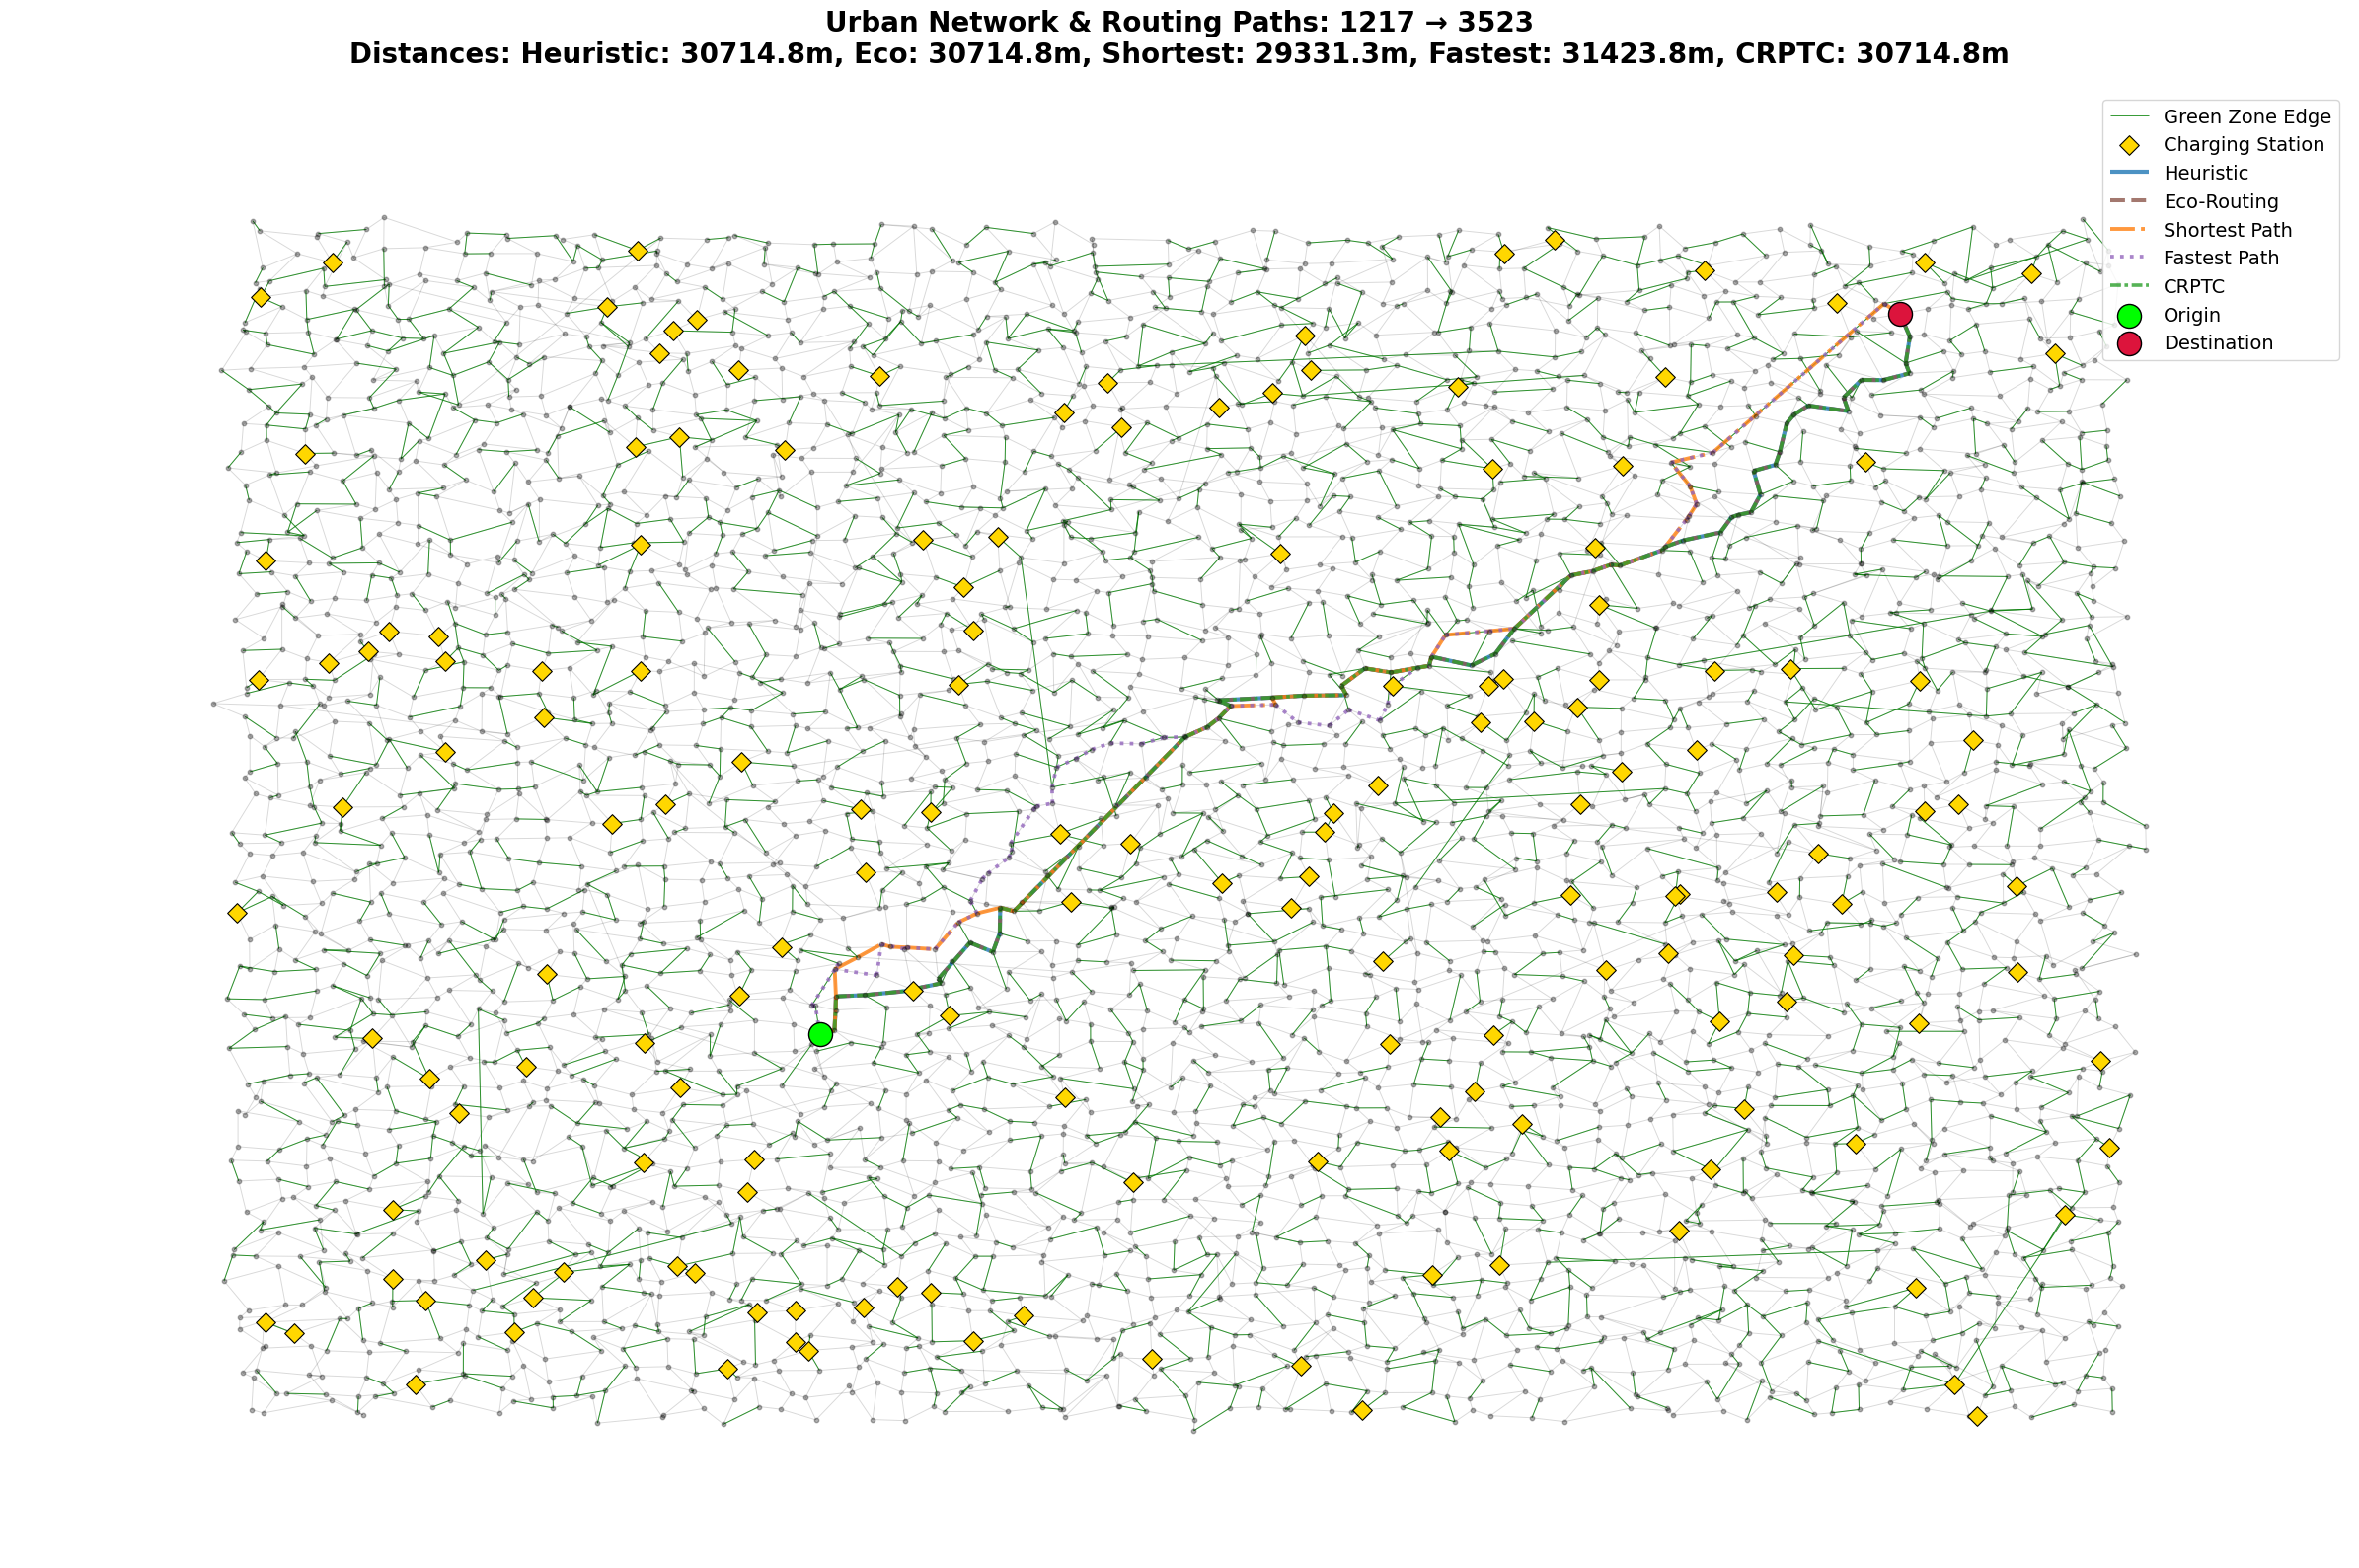

In [31]:
def visualize_all_algorithms_paths(road_network, od_pairs):
    """
    Visualize paths from all routing algorithms on a 2D map, highlighting:
      - Green zone edges in bright green with increased line width
      - Charging stations as gold diamonds with black borders
      - All routing paths (Heuristic, Eco-Routing, Shortest Path, Fastest Path, CRPTC) in distinct colors & styles
      - Origin (lime) and destination (crimson)

    Selects an OD pair where paths from all algorithms exist.
    """
    import matplotlib.pyplot as plt
    import networkx as nx

    # Compute distance of a path
    def compute_path_distance(path, graph):
        return sum(graph[u][v]['length'] for u, v in zip(path[:-1], path[1:]))

    # 1. Find suitable OD pair where all algorithms find a path
    valid_pairs = []
    print("Searching for OD pairs where all algorithms find a valid path...")

    for i, (origin, destination) in enumerate(od_pairs):
        try:
            # Try all algorithms
            h_path, h_energy, _ = heuristic_routing_algorithm(road_network, origin, destination, VEHICLE_PARAMS_SPORT_CAR)
            e_path, e_energy, _ = eco_routing_algorithm(road_network, origin, destination, VEHICLE_PARAMS_SPORT_CAR)
            s_path, s_energy, _ = shortest_path_distance(road_network, origin, destination, VEHICLE_PARAMS_SPORT_CAR)
            f_path, f_energy, _ = fastest_path_time(road_network, origin, destination, VEHICLE_PARAMS_SPORT_CAR)
            c_path, c_energy, _ = crptc_algorithm(road_network, origin, destination, VEHICLE_PARAMS_SPORT_CAR)

            # Check if all paths exist and are valid
            if (len(h_path) > 1 and len(e_path) > 1 and len(s_path) > 1 and
                len(f_path) > 1 and len(c_path) > 1):

                # Calculate path distances
                h_dist = compute_path_distance(h_path, road_network)
                e_dist = compute_path_distance(e_path, road_network)
                s_dist = compute_path_distance(s_path, road_network)
                f_dist = compute_path_distance(f_path, road_network)
                c_dist = compute_path_distance(c_path, road_network)

                # Get average distance
                avg_dist = (h_dist + e_dist + s_dist + f_dist + c_dist) / 5

                valid_pairs.append({
                    'origin': origin,
                    'destination': destination,
                    'distance': avg_dist,
                    'h_path': h_path,
                    'e_path': e_path,
                    's_path': s_path,
                    'f_path': f_path,
                    'c_path': c_path
                })
                print(f"Found valid OD pair {i+1}: {origin}-{destination}, avg distance: {avg_dist:.2f}m")

                # If we found at least 3 valid pairs, we can stop searching
                if len(valid_pairs) >= 3:
                    break
        except Exception as e:
            # Skip pairs with errors
            continue

    if not valid_pairs:
        print("No OD pairs found where all algorithms successfully find paths.")
        return

    # Select the OD pair with the longest average distance
    selected_pair = max(valid_pairs, key=lambda x: x['distance'])
    origin = selected_pair['origin']
    destination = selected_pair['destination']
    avg_distance = selected_pair['distance']

    print(f"Selected OD Pair: {origin} → {destination}, Avg Distance: {avg_distance:.2f} m")

    # Get all paths from the selected pair
    h_path = selected_pair['h_path']
    e_path = selected_pair['e_path']
    s_path = selected_pair['s_path']
    f_path = selected_pair['f_path']
    c_path = selected_pair['c_path']

    # 3. Prepare data structures for plotting
    paths_dict = {
        "Heuristic": h_path,
        "Eco-Routing": e_path,
        "Shortest Path": s_path,
        "Fastest Path": f_path,
        "CRPTC": c_path
    }

    route_colors = {
        "Heuristic": "#1f77b4",    # Classic blue
        "Eco-Routing": "#8c564b",  # Warm brown
        "Shortest Path": "#ff7f0e", # Bold orange
        "Fastest Path": "#9467bd",  # Cool purple
        "CRPTC": "#2ca02c"         # Green
    }

    route_styles = {
        "Heuristic": "solid",
        "Eco-Routing": "dashed",
        "Shortest Path": "dashdot",
        "Fastest Path": "dotted",
        "CRPTC": (0, (3, 1, 1, 1))  # Complex linestyle for CRPTC
    }

    # Node positions
    pos = nx.get_node_attributes(road_network, 'pos')

    # 4. Create figure
    plt.figure(figsize=(24, 16))  # Larger figure for clarity
    ax = plt.gca()

    # Draw entire network edges in a light gray color, thin lines
    nx.draw_networkx_edges(
        road_network, pos,
        alpha=0.15, width=0.7, edge_color="black"
    )

    # Highlight green zone edges
    green_edges = [(u, v) for (u, v) in road_network.edges() if road_network[u][v].get('in_green_zone', False)]
    if green_edges:
        nx.draw_networkx_edges(
            road_network, pos, edgelist=green_edges,
            edge_color="green", width=0.7, alpha=0.8,
            label="Green Zone Edge"
        )

    # Draw nodes in a subtle color, small size
    nx.draw_networkx_nodes(
        road_network, pos,
        node_size=10, node_color="black", alpha=0.3
    )

    # Charging stations (gold diamond, black border)
    charging_nodes = [n for n in road_network.nodes() if road_network.nodes[n].get('charging_station', False)]
    if charging_nodes:
        nx.draw_networkx_nodes(
            road_network, pos, nodelist=charging_nodes,
            node_color="gold", node_shape="D", node_size=100,
            edgecolors="black", linewidths=0.8,
            label="Charging Station"
        )

    # Overlay each route with distinct color & style - use offsets to make them visible when overlapping
    offsets = {
        "Heuristic": 0,
        "Eco-Routing": 0.3,
        "Shortest Path": 0.6,
        "Fastest Path": 0.9,
        "CRPTC": 1.2
    }

    # Draw paths with slight position offsets to make them more visible when overlapping
    for label, path in paths_dict.items():
        path_edges = list(zip(path[:-1], path[1:]))

        # Calculate modified positions with offset
        offset = offsets[label]
        offset_pos = {}
        for node in path:
            if node in pos:
                x, y = pos[node]
                offset_pos[node] = (x + offset/20, y + offset/20)

        # Draw the path with the modified positions
        nx.draw_networkx_edges(
            road_network, offset_pos if offset > 0 else pos,
            edgelist=path_edges,
            width=3 - (offset/3),  # Vary width slightly
            edge_color=route_colors[label],
            style=route_styles[label],
            label=label,
            alpha=0.8
        )

    # Mark origin and destination
    nx.draw_networkx_nodes(
        road_network, pos, nodelist=[origin],
        node_color="lime", node_size=300, edgecolors="black",
        linewidths=1.0, label="Origin"
    )
    nx.draw_networkx_nodes(
        road_network, pos, nodelist=[destination],
        node_color="crimson", node_size=300, edgecolors="black",
        linewidths=1.0, label="Destination"
    )

    # 5. Legend & title
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for h, l in zip(handles, labels):
        if l not in unique_labels:
            unique_labels.append(l)
            unique_handles.append(h)

    ax.legend(unique_handles, unique_labels, fontsize=14, loc="best", frameon=True)

    # Display path statistics
    title = f"Urban Network & Routing Paths: {origin} → {destination}\n"
    title += f"Distances: Heuristic: {compute_path_distance(h_path, road_network):.1f}m, "
    title += f"Eco: {compute_path_distance(e_path, road_network):.1f}m, "
    title += f"Shortest: {compute_path_distance(s_path, road_network):.1f}m, "
    title += f"Fastest: {compute_path_distance(f_path, road_network):.1f}m, "
    title += f"CRPTC: {compute_path_distance(c_path, road_network):.1f}m"

    ax.set_title(title, fontsize=20, fontweight="bold", pad=20)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_all_algorithms_paths(road_network, od_pairs)

In [32]:
def analyze_experiment_results(comp_results):
    """
    Analyze and visualize experiment results comparing multiple routing algorithms.
    Only includes data where all algorithms found successful routes.

    Parameters:
        comp_results (list): List of dictionaries containing experiment results
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from tabulate import tabulate
    from datetime import datetime

    print(f"Analysis Date and Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"User: kripa-sindhu-007\n")

    # Convert experiment results (list of dictionaries) into a DataFrame.
    comp_df = pd.DataFrame(comp_results)

    # Define the algorithms and their prefixes.
    algo_keys = {'h': 'Heuristic', 'e': 'Eco-Routing', 's': 'Shortest Path', 'f': 'Fastest Path', 'c': 'CRPTC'}
    algos = list(algo_keys.keys())

    # Filter to only include rows where all algorithms were successful
    success_columns = [f"{algo}_success" for algo in algos if f"{algo}_success" in comp_df.columns]
    if success_columns:
        filtered_df = comp_df[comp_df[success_columns].all(axis=1)].copy()
        print(f"Original data points: {len(comp_df)}")
        print(f"Data points with successful routes from all algorithms: {len(filtered_df)}")
        print(f"Percentage of successful cases: {len(filtered_df)/len(comp_df)*100:.2f}%\n")
    else:
        filtered_df = comp_df.copy()
        print("No success columns found. Using all data points.")

    # If no filtered data points remain, fall back to using all data
    if len(filtered_df) == 0:
        filtered_df = comp_df.copy()
        print("Warning: No cases with all algorithms successful. Falling back to all data.")

    # Define the metrics to display in the absolute summary table.
    abs_metrics = {
        'energy': 'Energy Consumed (kWh)',
        'time': 'Time Taken (s)',
        'cost': 'Total Cost ($)',
        'green_coverage': 'Green Zone Coverage (%)',
        'v2g_incentives': 'V2G Incentives ($)'
    }
    # Optionally include distance if available.
    if 'h_distance' in filtered_df.columns or 'distance' in filtered_df.columns:
        abs_metrics['distance'] = 'Distance Travelled (m)'

    # -----------------------------------------------------------------------------
    # Part 1: Absolute Summary Table (mean ± std) for all algorithms
    abs_summary = []
    for metric_key, metric_label in abs_metrics.items():
        for algo in algos:
            col = f"{algo}_{metric_key}"
            if col in filtered_df.columns:
                # Use only finite values for calculations
                valid_values = filtered_df[col][np.isfinite(filtered_df[col])]
                if len(valid_values) > 0:
                    mean_val = valid_values.mean()
                    std_val = valid_values.std()
                    abs_summary.append({
                        "Metric": metric_label,
                        "Algorithm": algo_keys[algo],
                        "Average": mean_val,
                        "Std Dev": std_val,
                        "Valid Samples": len(valid_values)
                    })

    abs_summary_df = pd.DataFrame(abs_summary)
    if not abs_summary_df.empty:
        abs_table = abs_summary_df.pivot(index="Metric", columns="Algorithm", values=["Average", "Std Dev", "Valid Samples"]).round(2)
        print("===== Absolute Metrics (per OD Pair) =====")
        print(tabulate(abs_table, headers="keys", tablefmt="pretty"))
    else:
        print("No valid data for absolute metrics summary.")

    # -----------------------------------------------------------------------------
    # Part 2: Percentage Improvement (Heuristic vs Others)
    # Dictionary to hold comparison data between algorithms
    comparisons = {
        'h_vs_e': 'Heuristic vs Eco-Routing',
        'h_vs_c': 'Heuristic vs CRPTC'
    }

    rel_metrics = {}
    for comparison, comp_label in comparisons.items():
        rel_metrics[comparison] = {}
        base_algo = comparison.split('_')[2]  # 'e' or 'c'

        for metric_key, metric_label in abs_metrics.items():
            h_col = f"h_{metric_key}"
            base_col = f"{base_algo}_{metric_key}"

            # Skip if columns don't exist or for special metrics
            if metric_key in ['v2g_incentives', 'green_coverage'] or base_col not in filtered_df.columns or h_col not in filtered_df.columns:
                continue

            # Filter for rows where both values are valid
            valid_indices = filtered_df[(np.isfinite(filtered_df[h_col])) & (np.isfinite(filtered_df[base_col]))].index
            if len(valid_indices) == 0:
                continue

            # Calculate improvement: ((Base - Heuristic)/Base)*100
            # Use only rows with valid values in both columns
            tmp_df = filtered_df.loc[valid_indices].copy()
            # Replace zeros with small value to avoid division by zero
            tmp_base_col = tmp_df[base_col].replace(0, 1e-10)
            improvement = ((tmp_base_col - tmp_df[h_col]) / tmp_base_col) * 100
            rel_metrics[comparison][metric_key] = improvement

    # Build a summary table for percentage improvements.
    rel_summary = []
    for metric_key, metric_label in abs_metrics.items():
        row = {"Metric": metric_label + " Improvement (%)"}

        for comparison, comp_label in comparisons.items():
            if metric_key in rel_metrics[comparison]:
                mean_impr = rel_metrics[comparison][metric_key].mean()
                std_impr = rel_metrics[comparison][metric_key].std()
                sample_size = len(rel_metrics[comparison][metric_key])
                row[comp_label] = f"{mean_impr:.2f} ± {std_impr:.2f} (n={sample_size})"

        if len(row) > 1:  # Add row only if it has data beyond the metric name
            rel_summary.append(row)

    rel_summary_df = pd.DataFrame(rel_summary)
    if not rel_summary_df.empty:
        print("\n===== Percentage Improvement (Heuristic vs Other Algorithms) =====")
        print(tabulate(rel_summary_df, headers="keys", tablefmt="pretty"))
    else:
        print("No valid data for percentage improvement summary.")

    # -----------------------------------------------------------------------------
    # Part 3: Graphs

    # (A) Subplots for Absolute Metrics (one subplot per metric)
    metrics_with_data = [m for m in abs_metrics if any(f"{a}_{m}" in filtered_df.columns for a in algos)]
    if metrics_with_data:
        num_metrics = len(metrics_with_data)
        fig, axes = plt.subplots(1, num_metrics, figsize=(6*num_metrics, 8))
        if num_metrics == 1:
            axes = [axes]  # Make axes iterable when there's only one subplot

        base_colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']  # Added extra color for CRPTC

        for i, (metric_key, metric_label) in enumerate([(k, v) for k, v in abs_metrics.items() if k in metrics_with_data]):
            if i >= len(axes):
                break

            ax = axes[i]
            means = []
            stds = []
            labels = []

            for algo in algos:
                col = f"{algo}_{metric_key}"
                if col in filtered_df.columns:
                    valid_values = filtered_df[col][np.isfinite(filtered_df[col])]
                    if len(valid_values) > 0:
                        means.append(valid_values.mean())
                        stds.append(valid_values.std())
                        labels.append(algo_keys[algo])

            if means:  # Only plot if we have data
                x = np.arange(len(labels))
                c_slice = base_colors[:len(labels)]
                bars = ax.bar(x, means, yerr=stds, capsize=5, color=c_slice)

                # Add value labels on top of bars
                for bar_idx, bar in enumerate(bars):
                    height = bar.get_height()
                    if np.isfinite(height):
                        ax.text(bar.get_x() + bar.get_width()/2., height + (stds[bar_idx]*0.2 if np.isfinite(stds[bar_idx]) else 0),
                                f'{height:.2f}',
                                ha='center', va='bottom', rotation=0,
                                fontsize=9, fontweight='bold')

                ax.set_xticks(x)
                ax.set_xticklabels(labels, rotation=45)
                ax.set_title(metric_label, fontsize=12, fontweight='bold')
                ax.set_ylabel(metric_label)

                # Set y-axis to start at 0 for most metrics (except those that can be negative)
                if metric_key not in ['energy', 'v2g_incentives']:
                    ax.set_ylim(bottom=0)

        plt.suptitle("Absolute Metrics Comparison Across Algorithms\n(Only including cases where all algorithms succeeded)",
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    # (B) Side-by-side comparisons for Percentage Improvement (Heuristic vs Others)
    # Create a structured dataframe for plotting
    plot_data = []
    for comparison, comp_label in comparisons.items():
        for metric_key, metric_label in abs_metrics.items():
            if metric_key in rel_metrics[comparison]:
                values = rel_metrics[comparison][metric_key]
                if len(values) > 0:
                    mean_impr = values.mean()
                    std_impr = values.std()
                    plot_data.append({
                        "Metric": metric_label,
                        "Comparison": comp_label,
                        "Average Improvement (%)": mean_impr,
                        "Std Dev": std_impr,
                        "Sample Size": len(values)
                    })

    if plot_data:
        plot_df = pd.DataFrame(plot_data)

        plt.figure(figsize=(10, 7))
        ax = plt.gca()

        # Use seaborn for a more informative grouped bar chart
        sns.barplot(x="Metric", y="Average Improvement (%)", hue="Comparison", data=plot_df, ax=ax)

        # Add value labels on bars
        for i, p in enumerate(ax.patches):
            height = p.get_height()
            if not np.isnan(height):  # Avoid NaN values
                ax.text(p.get_x() + p.get_width()/2.,
                        height + (0.5 if height >= 0 else -2.5),
                        f'{height:.1f}%',
                        ha='center', va='bottom' if height >= 0 else 'top',
                        fontsize=9, fontweight='bold')

        ax.set_title("Average Percentage Improvement (Heuristic vs Other Algorithms)\n(Only including cases where all algorithms succeeded)",
                    fontsize=16, fontweight='bold')
        ax.set_ylabel("Improvement (%)")
        ax.set_xlabel("")
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)  # Add zero line for reference
        plt.xticks(rotation=45, ha='right')
        plt.legend(title="Comparison")
        plt.tight_layout()
        plt.show()

        # (C) Box plots for a better view of the distribution
        plt.figure(figsize=(12, 6))
        for comparison, comp_label in comparisons.items():
            metrics_data = []
            metric_names = []

            for metric_key, metric_label in abs_metrics.items():
                if metric_key in rel_metrics[comparison]:
                    values = rel_metrics[comparison][metric_key]
                    if len(values) > 0:
                        metrics_data.append(values)
                        metric_names.append(metric_label)

            if metrics_data:
                plt.boxplot(metrics_data, positions=np.arange(len(metrics_data)) + (0.3 if comparison == 'h_vs_e' else 0),
                          widths=0.25, patch_artist=True,
                          boxprops=dict(facecolor='lightblue' if comparison == 'h_vs_e' else 'lightgreen'),
                          medianprops=dict(color='red'),
                          flierprops=dict(marker='o', markerfacecolor='red', markersize=3))

        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)  # Add zero line
        plt.xticks(np.arange(len(metric_names)), metric_names, rotation=45, ha='right')
        plt.ylabel('Improvement (%)')
        plt.title('Distribution of Improvements by Metric (Heuristic vs Others)\n(Only including cases where all algorithms succeeded)', fontsize=14)

        # Add a custom legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='lightblue', edgecolor='black', label='Heuristic vs Eco-Routing'),
            Patch(facecolor='lightgreen', edgecolor='black', label='Heuristic vs CRPTC')
        ]
        plt.legend(handles=legend_elements)

        plt.tight_layout()
        plt.show()

    return abs_summary_df, rel_summary_df

Analysis Date and Time: 2025-12-25 06:01:45
User: kripa-sindhu-007

No success columns found. Using all data points.
===== Absolute Metrics (per OD Pair) =====
+-------------------------+----------------------+----------------------------+--------------------------+----------------------+----------------------------+--------------------------+----------------------------+----------------------------------+--------------------------------+
|         Metric          | ('Average', 'CRPTC') | ('Average', 'Eco-Routing') | ('Average', 'Heuristic') | ('Std Dev', 'CRPTC') | ('Std Dev', 'Eco-Routing') | ('Std Dev', 'Heuristic') | ('Valid Samples', 'CRPTC') | ('Valid Samples', 'Eco-Routing') | ('Valid Samples', 'Heuristic') |
+-------------------------+----------------------+----------------------------+--------------------------+----------------------+----------------------------+--------------------------+----------------------------+----------------------------------+-------------------------

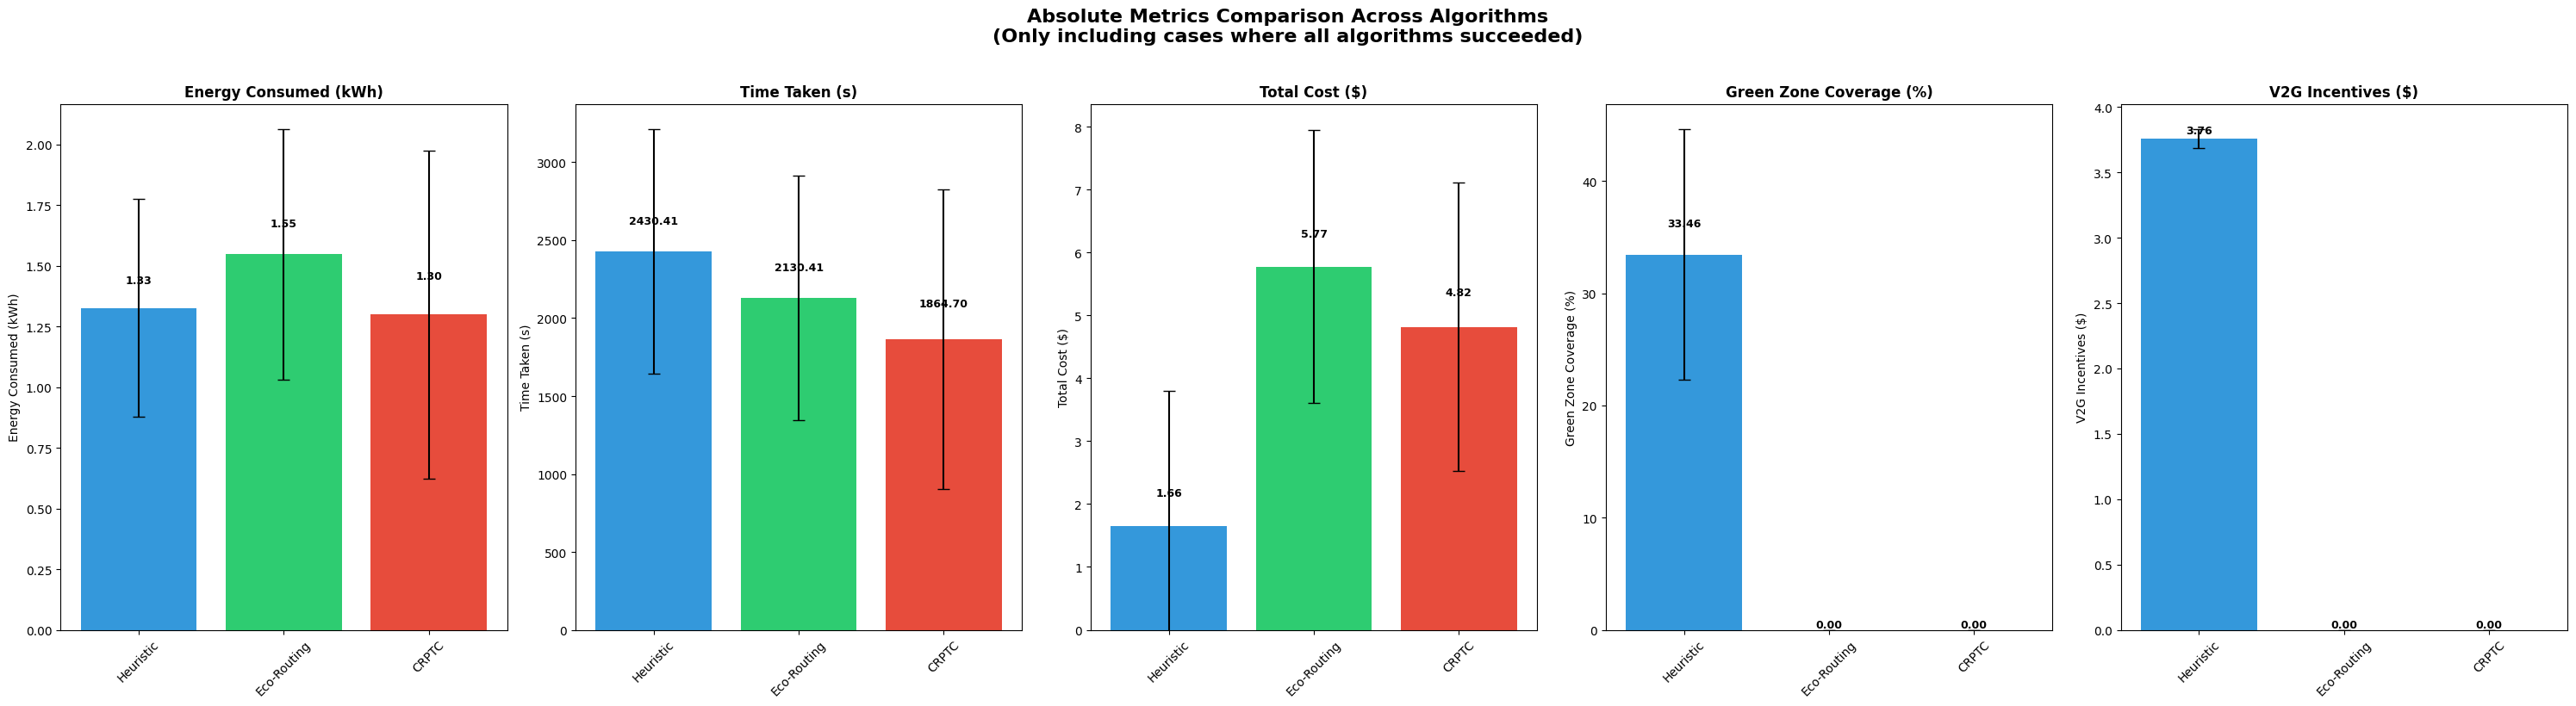

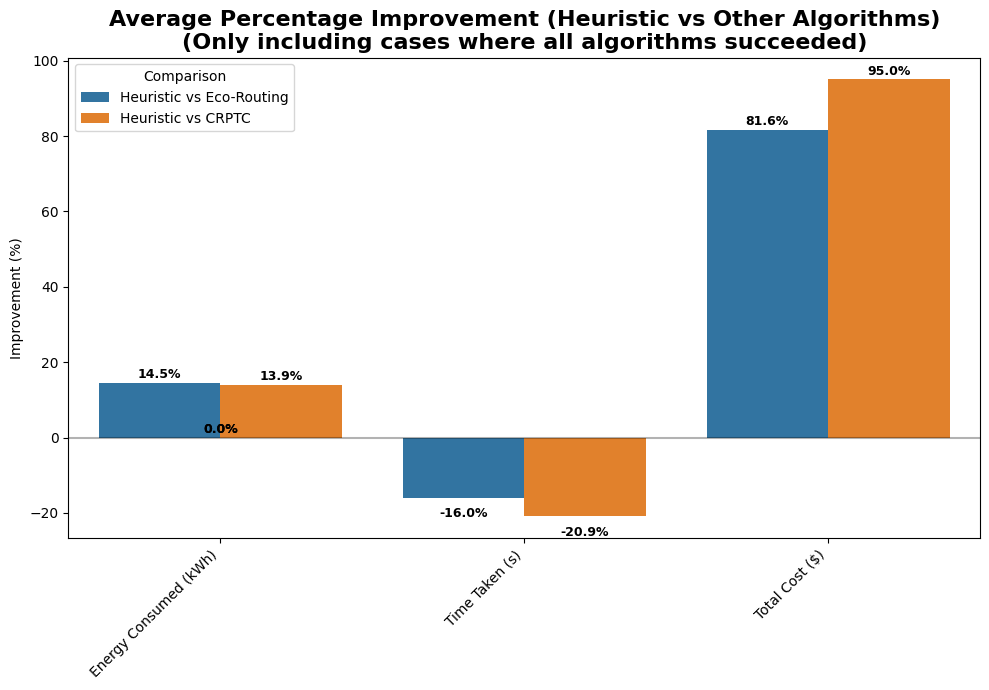

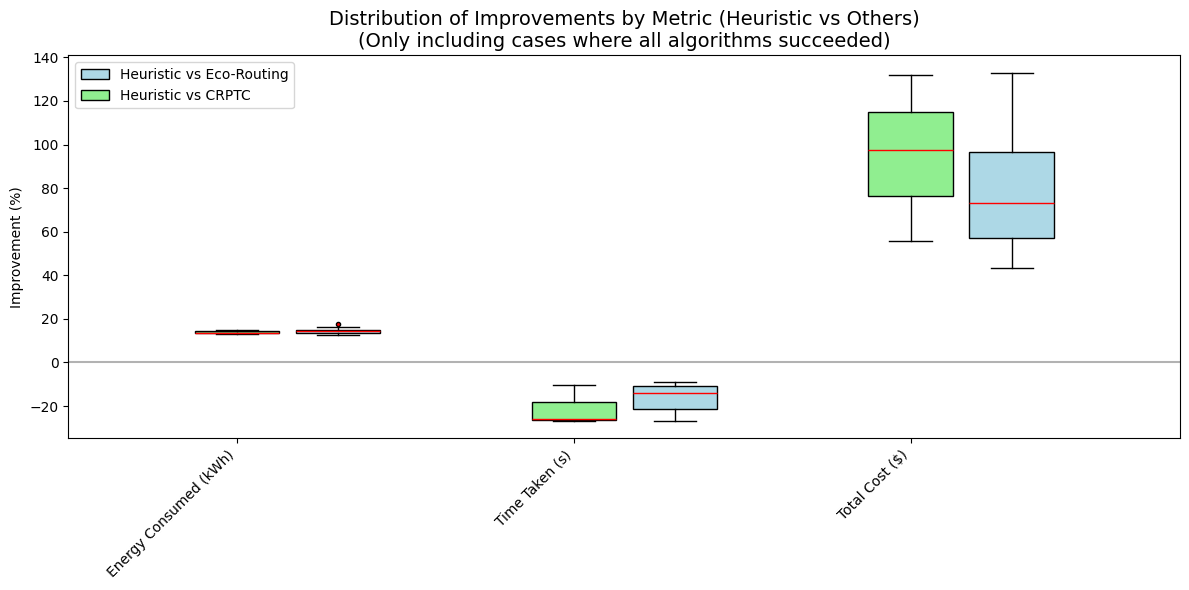

In [33]:
# Assuming comp_results is your list of experiment results dictionaries
abs_metrics, rel_metrics = analyze_experiment_results(comp_results)